In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader.data as web
import datetime
import math
import seaborn as sns
import quandl
pd.set_option('precision',4)
api_key = quandl.ApiConfig.api_key = 'XXX'
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [152]:
start = datetime.datetime(1974,12,31)
end = datetime.datetime(2018,6,15)

In [155]:
spx = quandl.get("CHRIS/CME_SP1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Settle'].rename('spx')
aaii = quandl.get("AAII/AAII_SENTIMENT", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Bull-Bear Spread'].rename('aaii')

In [156]:
#SPX COT Position
spx_cot = quandl.get("CFTC/13874A_FO_ALL", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")
spx_cot = spx_cot.loc[:,'Open Interest':'Leveraged Funds Shorts']
spx_cot['spx_positions'] = (spx_cot['Asset Manager Longs'] - spx_cot['Asset Manager Shorts'] + spx_cot['Leveraged Funds Longs'] - 
    spx_cot['Leveraged Funds Longs'])

In [157]:
#HF CTA and HF Global beta 
cta = pd.read_csv('hfrx_cta.csv',index_col=0,parse_dates=True,header=0,skipfooter=7,engine='python')
h_global = pd.read_csv('hfrx_global.csv',index_col=0,parse_dates=True,header=0,skipfooter=7,engine='python')
cta.sort_index(ascending=True,inplace=True)
cta.columns = ['cta_chg','cta']
cta = cta.loc['01-02-2009':,:]
h_global.sort_index(ascending=True,inplace=True)
h_global.columns = ['global_chg','global']
h_global = h_global.loc['01-02-2009':,:]

beta = pd.concat([spx.pct_change(1),h_global['global_chg'],cta['cta_chg']],axis=1)

beta['global'] = beta['spx'].rolling(window=21).cov(beta['global_chg'])/beta['spx'].rolling(window=21).var()
beta['cta'] = beta['spx'].rolling(window=21).cov(beta['cta_chg'])/beta['spx'].rolling(window=21).var()
beta.dropna(inplace=True)

X = pd.DataFrame(list(range(len(beta.loc[:'04-30-2014',:])))).values.reshape(-1,1)
y = beta['global'].loc[:'04-30-2014']
global_lr = LinearRegression()
global_lr.fit(X,y)
global_lr = pd.DataFrame(global_lr.predict(X),index=beta.loc[:'04-30-2014'].index,columns=['global_lr'])
beta = beta.join(global_lr)

beta['pre_global'] = (beta.loc[:'04-30-2014','global']-beta['global_lr'])
beta['post_global'] = beta.loc['05-01-2014':,'global']

beta['pre_z'] = pd.DataFrame(StandardScaler().fit_transform(beta.loc[:'04-30-2014','pre_global'].values.reshape(-1,1)),
                            index=beta.loc[:'04-30-2014'].index)
beta['post_z'] = pd.DataFrame(StandardScaler().fit_transform(beta.loc['05-01-2014':,'post_global'].values.reshape(-1,1)),
                            index=beta.loc['05-01-2014':].index)

beta['global_adj'] = beta.loc[:'04-30-2014','pre_z'].append(beta.loc['05-01-2014':,'post_z'])
#for some reason there are a couple dates missing - idk why

In [158]:
#Put Call Ratio
putcallratio = pd.read_csv('putcallratio.csv',index_col=0,parse_dates=True,skiprows=2)
putcallratio = putcallratio['CALL']/putcallratio['PUT']
putcallratio = pd.DataFrame(StandardScaler().fit_transform(putcallratio.values.reshape(-1,1)),index=putcallratio.index,
                           columns=['putcallratio'])
putcallratio.drop(putcallratio['2010-07-06':].index,inplace=True)

spx_pcratio = pd.read_csv('spx_pcratio.csv',index_col=0,parse_dates=True,skiprows=1)
spx_pcratio = spx_pcratio['SPX Call Volume']/spx_pcratio['SPX Put Volume']
spx_pcratio = pd.DataFrame(StandardScaler().fit_transform(spx_pcratio.values.reshape(-1,1)),index=spx_pcratio.index,
                           columns=['spx_pcratio'])

putcallratio = pd.concat([putcallratio,spx_pcratio],axis=1)
putcallratio = putcallratio.loc[:'2010-07-02','putcallratio'].append(putcallratio.loc['2010-07-06':,'spx_pcratio'])
putcallratio = putcallratio.rolling(20).mean()
putcallratio = putcallratio.rename('putcallratio')

In [159]:
#Skew Index
skew = pd.read_csv('skewindex.csv',index_col=0,parse_dates=True, skiprows=1)
skew = skew['SKEW'].rename('skew')
skew.dropna(inplace=True)
skew = skew/-1
skew = pd.DataFrame(skew,index=skew.index,columns=['skew'])

X = pd.DataFrame(list(range(len(skew.loc['12-31-2009':])))).values.reshape(-1,1)
y = skew.loc['12-31-2009':]
skew_lr = LinearRegression()
skew_lr.fit(X,y)
skew_lr = pd.DataFrame(skew_lr.predict(X),index=skew.loc['12-31-2009':].index,columns=['skew_lr'])

skew['pre_z'] = pd.DataFrame(StandardScaler().fit_transform(skew.loc[:'12-30-2009','skew'].values.reshape(-1,1)),
                            index=skew.loc[:'12-30-2009','skew'].index)
skew['post_z'] = pd.DataFrame(StandardScaler().fit_transform((skew.loc['12-31-2009':,'skew']-skew_lr['skew_lr']).values.reshape(-1,1)),
                            index=skew.loc['12-31-2009':,'skew'].index)
skew['skew_adj'] = skew.loc[:'12-30-2009','pre_z'].append(skew.loc['12-31-2009':,'post_z'])
skew['skew_adj_rol'] = skew['skew_adj'].rolling(20).mean()

In [160]:
vix = web.DataReader('^VIX', 'yahoo',start,end)['Adj Close']
vix = vix/-1
vix = vix.rolling(20).mean()
vix = vix.rename('vix')

In [161]:
#import eco_data
spx = quandl.get("CHRIS/CME_SP1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Settle'].rename('spx')
cons_conf = quandl.get("UMICH/SOC1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Index'].rename('cons_conf')
dur_goods = quandl.get("FRED/DGORDER", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('dur_goods')
cap_goods = quandl.get("FRED/NEWORDER", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('cap_goods')
retail_sales = quandl.get("FRED/RSXFS", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('retail_sales')
auto_sales = quandl.get("FRED/ALTSALES", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('auto_sales')
ind_prod = quandl.get("FRED/INDPRO", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('ind_prod')
pmi = quandl.get("ISM/MAN_PMI", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['PMI'].rename('pmi')

In [162]:
#create and scale eco_ind data
t=6

spx_m = pd.DataFrame(spx)
spx_m = spx_m.resample('M').last()
spx_m['spx_12mpchg'] = spx_m['spx'].pct_change(t)

cons_conf = cons_conf.pct_change(t)
cons_conf = cons_conf.resample('M').last()

dur_goods = dur_goods.pct_change(t)
dur_goods = dur_goods.resample('M').last()

cap_goods = cap_goods.pct_change(t)
cap_goods = cap_goods.resample('M').last()

retail_sales = retail_sales.pct_change(t)
retail_sales = retail_sales.resample('M').last()

auto_sales = auto_sales.pct_change(t)
auto_sales = auto_sales.resample('M').last()

ind_prod = ind_prod.pct_change(t)
ind_prod = ind_prod.resample('M').last()

#pmi = pmi.resample('M').last()

bc_ind = pd.concat([spx_m,cons_conf,dur_goods,cap_goods,retail_sales,auto_sales,ind_prod],axis=1)
bc_ind.dropna(inplace=True)

bc_ind_scaled = StandardScaler().fit_transform(bc_ind.iloc[:,2:])
bc_ind = pd.DataFrame(bc_ind_scaled,index=bc_ind.index,columns=bc_ind.iloc[:,2:].columns)
bc_ind = pd.concat([spx_m,bc_ind],axis=1)
bc_ind.dropna(inplace=True)

In [163]:
#Calculate residuals of eco_ind
X = bc_ind.iloc[:,2:]
y = bc_ind['spx_12mpchg']

lr_bc_ind = LinearRegression().fit(X,y).predict(X)
lr_bc_ind = pd.DataFrame(lr_bc_ind,index=X.index,columns=['lr_bc_ind'])
bc_ind = bc_ind.join(lr_bc_ind)
bc_ind['bc_sent'] = bc_ind['spx_12mpchg']-bc_ind['lr_bc_ind']
bc_ind['bc_sent'] = bc_ind['bc_sent'].rolling(3).mean()
bc_ind = bc_ind.resample('M').last()

In [164]:
#Confidence
umich_conf = quandl.get("UMICH/SOC1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Index'].rename('umich_conf')
oecd_conf = quandl.get("OECD/KEI_CSCICP02_USA_ST_M", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('oecd_conf')
umich_conf = umich_conf.resample('M').last()
oecd_conf = oecd_conf.resample('M').last()
cons_conf_df = pd.concat([umich_conf,oecd_conf],axis=1)
cons_conf_df.dropna(inplace=True)

cons_conf_df_scaled = pd.DataFrame(StandardScaler().fit_transform(cons_conf_df),index=cons_conf_df.index,columns=cons_conf_df.columns)
cons_conf_df = cons_conf_df_scaled
cons_conf_df['cons_conf'] = cons_conf_df.mean(axis=1)

In [165]:
jpy = web.DataReader('DEXJPUS', 'fred',start,end)
jpy.columns = ['jpy']
copper = quandl.get("CHRIS/CME_HG1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Settle'].rename('copper')
gold = quandl.get("CHRIS/CME_GC1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Settle'].rename('gold')
spx = quandl.get("CHRIS/CME_SP1", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Settle'].rename('spx')
tsy = quandl.get("FRED/DGS10", paginate=True,start_date=start, end_date=end,authtoken="7a_oXSS9dgPgUi8wKyxp")['Value'].rename('tsy')
xly = web.DataReader('XLY', 'yahoo',start,end)['Adj Close'].rename('xly')
xlp = web.DataReader('XLP', 'yahoo',start,end)['Adj Close'].rename('xlp')
hyg = web.DataReader('HYG', 'yahoo',start,end)['Adj Close'].rename('hyg')
lqd = web.DataReader('LQD', 'yahoo',start,end)['Adj Close'].rename('lqd')

jpy = jpy.resample('w').last()
copper = copper.resample('w').last()
gold = gold.resample('w').last()
spx = spx.resample('w').last()
tsy = tsy.resample('w').last()
xly = xly.resample('w').last()
xlp = xlp.resample('w').last()
hyg = hyg.resample('w').last()
lqd = lqd.resample('w').last()

liq_sent = pd.concat([jpy,copper,gold,spx,tsy,xly,xlp,hyg,lqd],axis=1)
liq_sent = liq_sent.pct_change(24)
liq_sent.dropna(inplace=True)
liq_sent = pd.DataFrame(StandardScaler().fit_transform(liq_sent),index=liq_sent.index,columns=liq_sent.columns)
liq_sent['cop_gold'] = liq_sent['copper']-liq_sent['gold']
liq_sent['spx_tsy'] = liq_sent['spx']-liq_sent['tsy']
liq_sent['xly_xlp'] = liq_sent['xly']-liq_sent['xlp']
liq_sent['hyg_lqd'] = liq_sent['hyg']-liq_sent['lqd']
liq_sent = pd.DataFrame(StandardScaler().fit_transform(liq_sent),index=liq_sent.index,columns=liq_sent.columns)
liq_sent = liq_sent.drop(liq_sent.loc[:,'copper':'lqd'],axis=1)
liq_sent['liq_sent'] = liq_sent.mean(axis=1)

In [166]:
csi = pd.concat([spx,skew['skew_adj'],aaii,putcallratio,spx_cot['spx_positions'],beta['global_adj'],beta['cta'],vix,
                bc_ind['bc_sent'],liq_sent['liq_sent']],axis=1)
csi['bc_sent'] = csi['bc_sent'].interpolate()
csi = csi.resample('w').last()
csi.dropna(inplace=True)
csi.iloc[:,1:] = pd.DataFrame(StandardScaler().fit_transform(csi.iloc[:,1:]),index=csi.index,columns=csi.iloc[:,1:].columns)

In [167]:
X = csi.iloc[:,1:]

csi['pca'] = pd.DataFrame(PCA(n_components=1).fit_transform(X),index=X.index,columns=['pca'])
csi['pca'] = pd.DataFrame(StandardScaler().fit_transform(csi['pca'].values.reshape(-1,1)),index=X.index,columns=['pca'])*-1
csi['csi'] = csi.iloc[:,1:].mean(axis=1)
csi['csi'] = pd.DataFrame(StandardScaler().fit_transform(csi['csi'].values.reshape(-1,1)),index=X.index,columns=['csi'])

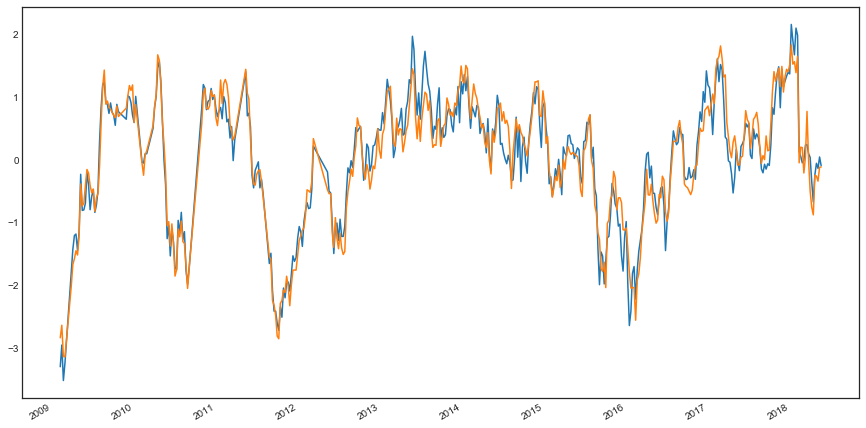

In [168]:
plt.figure(figsize=[15,8])
csi['csi'].plot()
#csi['spx'].pct_change(8).plot()
csi['pca'].plot()
#csi['pca'].rank(pct=True).plot()

In [169]:
def spx_fret_cut(df,feat,bins,ft):
    cut = pd.cut(df[feat],bins,labels=np.arange(1,bins+1,1))
    cut_mean = df['spx'].pct_change(ft).shift(-ft).groupby(cut).mean()
    cut_median = df['spx'].pct_change(ft).shift(-ft).groupby(cut).median()
    return(pd.concat([cut_mean,cut_median],axis=1))

In [170]:
def spx_fret_qcut(df,feat,bins,ft):
    qcut = pd.qcut(df[feat],bins,labels=np.arange(1,bins+1,1))
    qcut_mean = df['spx'].pct_change(ft).shift(-ft).groupby(qcut).mean()
    return(pd.concat([qcut_mean],axis=1))
    #qcut_median = df['spx'].pct_change(ft).shift(-ft).groupby(qcut).median()
    #return(pd.concat([qcut_mean,qcut_median],axis=1))

In [171]:
def bplot_4(func,df,feat):
    fig,ax = plt.subplots(2,2,figsize=[20,12])
    func(df,feat,20,4).plot(kind='bar',cmap = 'coolwarm',ax=ax[0,0])
    func(df,feat,20,8).plot(kind='bar',cmap = 'coolwarm',ax=ax[0,1])
    func(df,feat,20,12).plot(kind='bar',cmap = 'coolwarm',ax=ax[1,0])
    func(df,feat,20,16).plot(kind='bar',cmap = 'coolwarm',ax=ax[1,1])
    plt.tight_layout()

In [172]:
def qcut_counts(df,feat,bins):
    qcut = pd.qcut(df[feat],bins,labels=np.arange(1,bins+1,1))
    cc = (pd.concat([df[feat].groupby(qcut).mean(),df[feat].groupby(qcut).count()/df[feat].count(),
               df[feat].groupby(qcut).count()],axis=1))
    cc.columns = ['qcut','pct_qcut','qcut_#']
    return(cc)

In [173]:
def cut_counts(df,feat,bins):
    cut = pd.cut(df[feat],bins,labels=np.arange(1,bins+1,1))
    cc = (pd.concat([df[feat].groupby(cut).mean(),df[feat].groupby(cut).count()/df[feat].count(),
               df[feat].groupby(cut).count()],axis=1))
    cc.columns = ['cut','pct_cut','cut_#']
    return(cc)

In [174]:
csi['spx_4wkf'] = csi['spx'].pct_change(4).shift(-4)
csi['spx_8wkf'] = csi['spx'].pct_change(8).shift(-8)
csi['spx_12wkf'] = csi['spx'].pct_change(12).shift(-12)
csi['spx_16wkf'] = csi['spx'].pct_change(16).shift(-16)

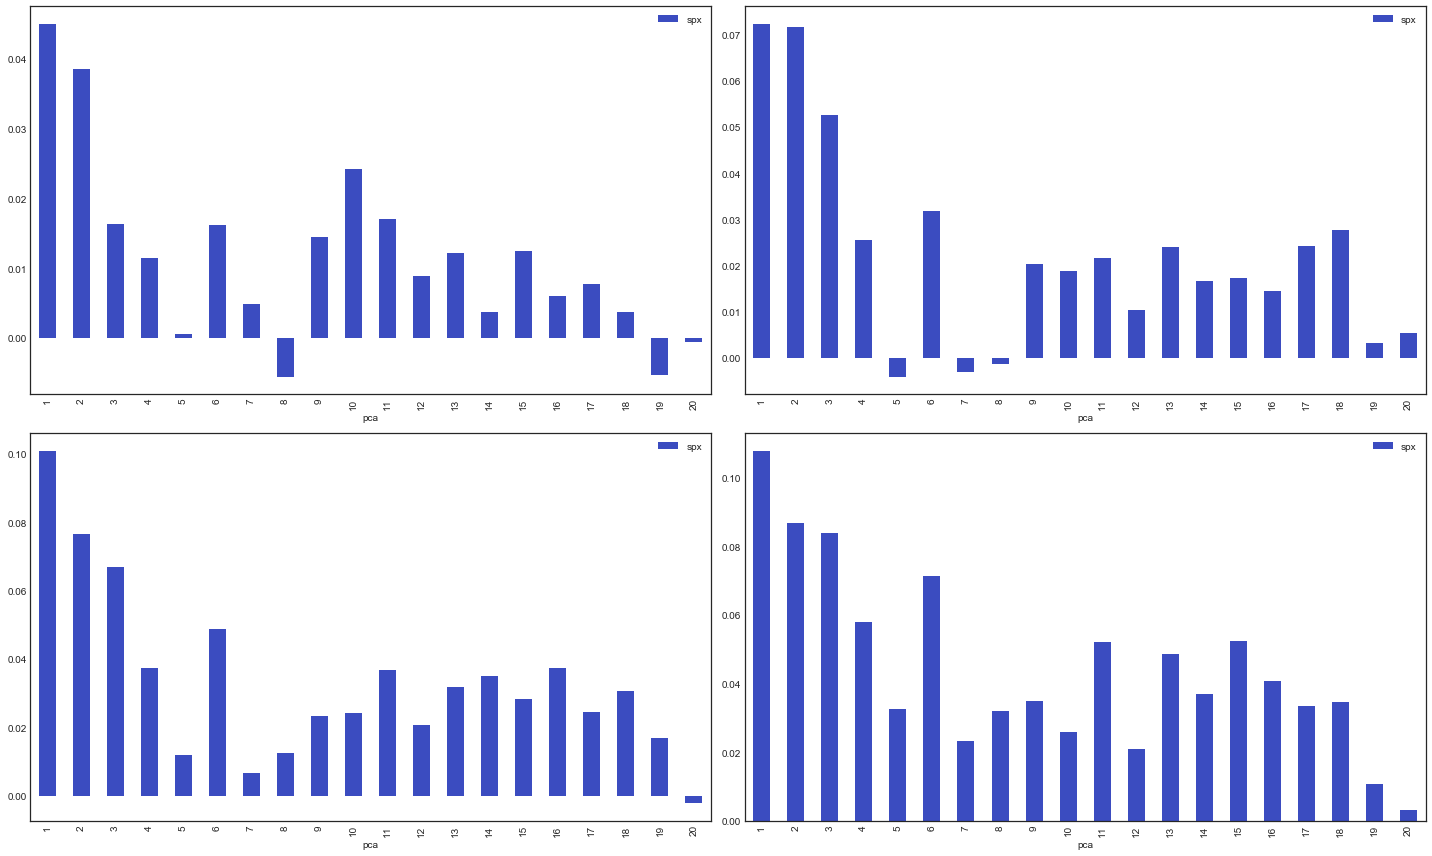

In [175]:
bplot_4(spx_fret_qcut,csi,'pca')

In [176]:
qcut_counts(csi,'cta',20)

,qcut,pct_qcut,qcut_#
cta,,,
1,-1.8343,0.0512,23
2,-1.4946,0.0490,22
3,-1.2603,0.0512,23
4,-1.0204,0.0490,22
5,-0.7854,0.0512,23
6,-0.5140,0.0490,22
7,-0.3583,0.0490,22
8,-0.2040,0.0512,23
9,-0.0889,0.0490,22


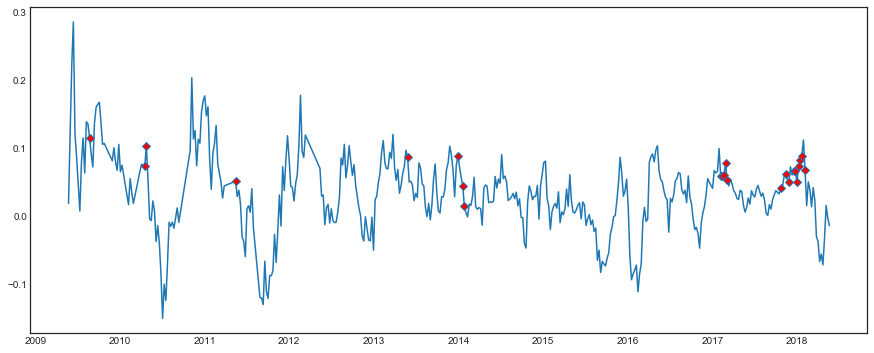

In [177]:
markers = [idx for idx,diff in enumerate(pd.qcut(csi['pca'],20,labels=np.arange(1,21,1))) if pd.qcut(csi['pca'],
        20,labels=np.arange(1,21,1))[idx]==20]

plt.figure(figsize=[15,6])
plt.plot(csi['spx'].pct_change(12),marker='D',markerfacecolor='r',markevery=markers)

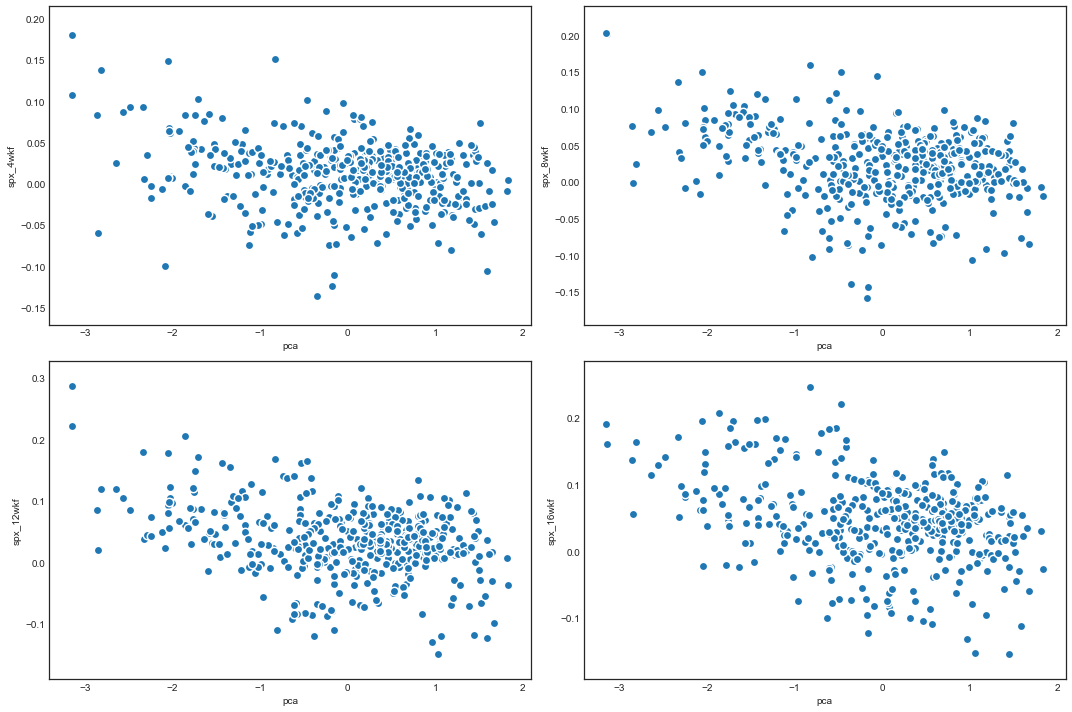

In [178]:
fig,ax = plt.subplots(2,2,figsize=[15,10])
csi.plot('pca','spx_4wkf',kind='scatter',edgecolor='white',s=70,lw=1.5,ax=ax[0,0])
csi.plot('pca','spx_8wkf',kind='scatter',edgecolor='white',s=70,lw=1.5,ax=ax[0,1])
csi.plot('pca','spx_12wkf',kind='scatter',edgecolor='white',s=70,lw=1.5,ax=ax[1,0])
csi.plot('pca','spx_16wkf',kind='scatter',edgecolor='white',s=70,lw=1.5,ax=ax[1,1])
plt.tight_layout()

In [179]:
def rank(df,x,y):
    rank = df.loc[:,x:y].rank(pct=True)
    plt.figure(figsize=[12,8])
    sns.heatmap(rank.iloc[-20:,:],annot=True,cmap='seismic')

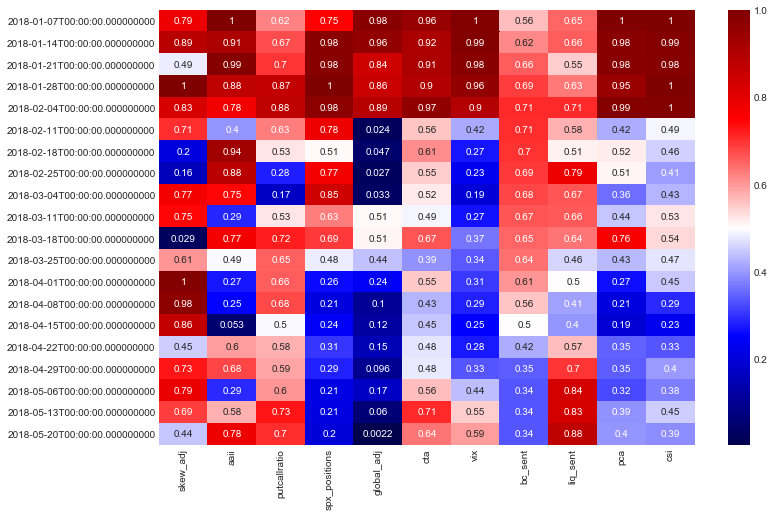

In [180]:
#figure out how to get rid of timestamp
rank(csi,'skew_adj','csi')

Text(0.5,1,'liq_sent')

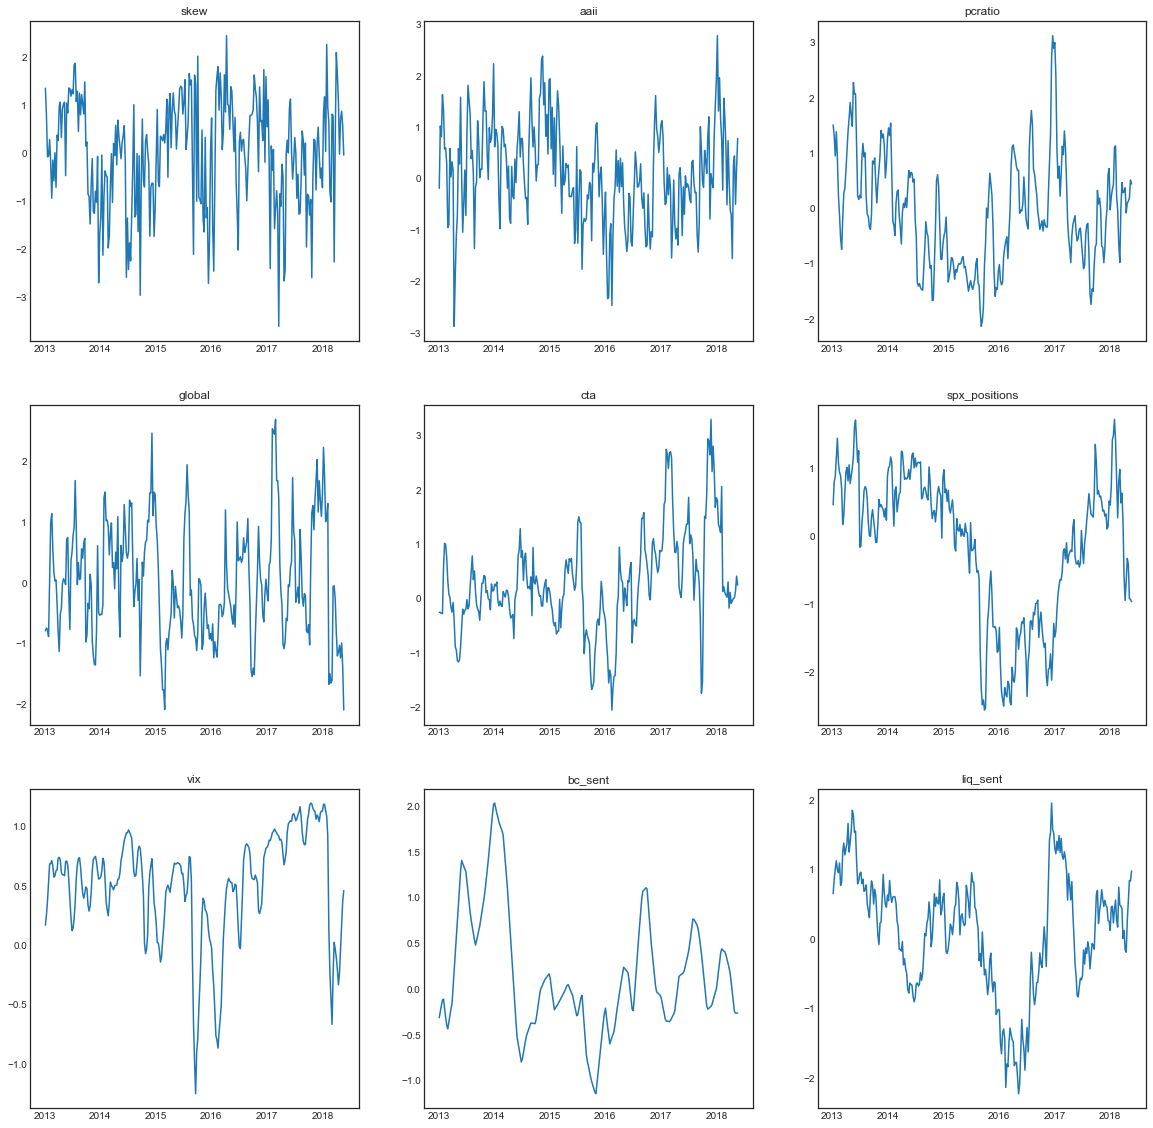

In [181]:
date1 = '12-31-2012'
date2 = '05-20-2018'
fig, sub = plt.subplots(3,3,figsize=[20,20])
sub[0,0].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'skew_adj'])
sub[0,0].set_title('skew')
sub[0,1].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'aaii'])
sub[0,1].set_title('aaii')
sub[0,2].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'putcallratio'])
sub[0,2].set_title('pcratio')
sub[1,0].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'global_adj'])
sub[1,0].set_title('global')
sub[1,1].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'cta'])
sub[1,1].set_title('cta')
sub[1,2].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'spx_positions'])
sub[1,2].set_title('spx_positions')
sub[2,0].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'vix'])
sub[2,0].set_title('vix')
sub[2,1].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'bc_sent'])
sub[2,1].set_title('bc_sent')
sub[2,2].plot(csi.loc[date1:date2].index,csi.loc[date1:date2,'liq_sent'])
sub[2,2].set_title('liq_sent')

In [182]:
X = csi.loc[:'12-31-2016','skew_adj':'liq_sent']
y = csi.loc[:'12-31-2016','spx_12wkf']
X_test = csi.loc['12-31-2016':'4-20-2018','skew_adj':'liq_sent']
y_test = csi.loc['12-31-2016':'4-20-2018','spx_4wkf']

rf = RandomForestRegressor(n_estimators=200).fit(X,y)
rf_pred = rf.predict(X)
print(r2_score(y,rf_pred))
print(rf.feature_importances_)

rf_pred_test = rf.predict(X_test)
print(r2_score(y_test,rf_pred_test))

0.9475663971963588
[0.05808468 0.08350108 0.13057476 0.08724023 0.08286974 0.0586804
 0.28506563 0.08344159 0.1305419 ]
-1.1045406373094258


In [183]:
knn = KNeighborsRegressor(n_neighbors=5).fit(X,y)
knn_pred = knn.predict(X)
print(r2_score(y,knn_pred))
print(r2_score(y_test,knn.predict(X_test)))

0.750676598872271
-1.651934812283049


Text(0,0.5,'Error Rate')

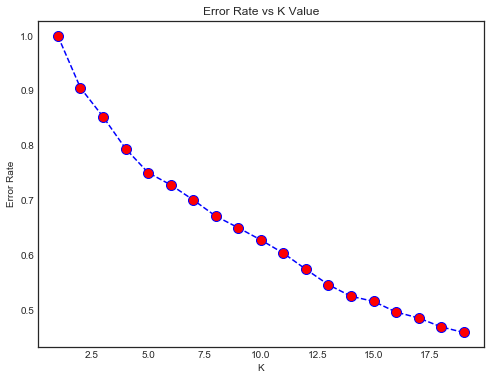

In [184]:
error_rate = []
for i in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X,y)
    pred_i = knn.predict(X)
    error_rate.append(r2_score(y,pred_i))
    #error_rate.append(np.mean(pred_i != y))
    
plt.figure(figsize = (8,6))
plt.plot(range(1,20),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')